<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  SVD en reconocimiento facial

En este caso-taller vamos a aplicar SVD para hacer reconocimiento facial. Esta aplicación se conoce como caras propias, o eigenfaces en inglés, y si bien es una forma rudimentaria de reconocimiento facial sus resultados pueden ser muy interesantes. El problema de las caras propias fue estudiado por primera vez por Sirovich y Kirby en 1987, ampliado en 1990 y su aplicación al reconocimiento facial automatizado fue presentado por Turk and Pentland en 1991.

En este taller vamos a utilizar la base de datos conocida como Caras Etiquetadas en la Naturaleza, o Labeled Faces in the Wild (LFW). Esta base es provista por la Universidad de Massachusetts Amherst para que la comunidad académica la utilice para la evaluación de modelos predictivos.

La base contiene más de 13.000 imágenes de rostros recopilados de la web y cada cara ha sido etiquetada con el nombre de la persona representada. Un subconjunto de 1.680 de las personas fotografiadas tienen dos o más fotos distintas en el conjunto de datos. 


 
#### Referencias

- G. B. Huang,  M. Ramesh, T. Berg, and E. Learned-Miller. Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments. University of Massachusetts, Amherst, Technical Report 07-49, October, 2007.

- M. Kirby and L. Sirovich. Application of the Karhunen-Loève procedure for the characterization of human faces. IEEE Transactions on Pattern Analysis and Machine Intelligence (PAMI), 12(1):103–108, 1990.

- L. Sirovich and M. Kirby. A low-dimensional procedure for the characterization of human faces. Journal of the Optical Society of America A, 4(3):519–524, 1987

- M. Turk and A. Pentland. Eigenfaces for recognition. Journal of Cognitive Neuroscience, 3(1):71–86, 1991.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "Revisión por el compañero".

4. El archivo entregado debe poder ser ejecutado localmente por los pares. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos  en la misma ruta de acceso del cuaderno, por ejemplo: `data`.

## Desarrollo


#### Config

##### Carga de Bibliotecas

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

# python
import os
import ssl
import sys
import csv
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from pathlib import Path
from inspect import cleandoc

# sklearn
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# skleann metrics
from sklearn.metrics import classification_report, recall_score

# numpy linear algebra
from numpy.linalg import svd


# typings
from pandas import DataFrame as PandasDF
from typing import List

# setup
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('max_colwidth', None)
# decimals
np.set_printoptions(precision=6)

##### Información de Sesión

In [2]:
session_info.show(html=False)

-----
matplotlib          3.10.0
numpy               1.26.4
pandas              2.3.1
seaborn             0.13.2
session_info        v1.0.1
sklearn             1.7.1
-----
IPython             8.37.0
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.10.11 (v3.10.11:7d4cc5aa85, Apr  4 2023, 19:05:19) [Clang 13.0.0 (clang-1300.0.29.30)]
macOS-10.15.7-x86_64-i386-64bit
-----
Session information updated at 2025-08-17 11:02


### utils

In [3]:
# utils

# desabilitar SSL verificacion para entornos locales
# cargar el dataset sklearn
if not os.environ.get('CI'):
    ssl._create_default_https_context =\
        ssl._create_unverified_context
          
# rutas absolutas
here: Path = Path.cwd().absolute()
data: Path = here / 'data'
file_lfw_people_img: Path = data / 'lfw_people_images.npy.npz'

### 1. Carga de datos 

Los datos pueden ser descargados directamente utilizando la librería `scikit-learn`, para ello cargue la base utilizando la función `fetch_lfw_people`. Esta función verificará si los datos están disponibles. De no estarlo, `scikit-learn` los descargará automáticamente desde el sitio web de la Universidad de Massachusetts. Descargue las imágenes para individuos que tengan al menos 25 imágenes y guárdelos en una carpeta llamada `data` usando esta función.

In [4]:
# Utilice este espacio para escribir el código.

# Carga el dataset LFW (Labeled Faces in the Wild)
# si no está en local (data/lfw_people_images.npy),
if not file_lfw_people_img.exists():
    lfw_people = fetch_lfw_people(
        min_faces_per_person=25,
        resize=0.4,
        color=False,
        data_home=str(data)
    )

    # Se guardan los datos localmente para un uso futuro más rápido
    np.savez_compressed(
        str(file_lfw_people_img),
        data=lfw_people.data,
        images=lfw_people.images,
        target=lfw_people.target,
        target_names=lfw_people.target_names
    )

(Utilice este espacio para describir su procedimiento)

### 2.  Análisis preliminar 

Describa los contenidos de la base, tenga en cuenta que debe detallar los elementos, la dimensión de la base, y la dimensión de las imágenes. 

In [5]:
# Utilice este espacio para escribir el código.
with np.load(
    str(file_lfw_people_img), 
    allow_pickle=True
) as data:
    lfw_data = data['data']
    lfw_images = data['images']
    lfw_target = data['target']
    lfw_target_names = data['target_names']

# Obtener las dimensiones del dataset
n_samples, n_features = lfw_data.shape
n_classes = len(lfw_target_names)
h, w = lfw_images.shape[1], lfw_images.shape[2]


print(cleandoc(f"""
    La base de datos contiene {n_samples} imágenes en total.
    Cada imagen está representada por {n_features} píxeles (un vector 1D).
    Las dimensiones originales de cada imagen son: {h} de alto x {w} de ancho.
    Hay un total de {n_classes} individuos diferentes en el dataset.
    
    Los elementos del dataset son:
    - data: Matriz donde cada fila es una imagen aplanada.
    - images: Array 3D con las imágenes en su formato original (alto x ancho).
    - target: Array con las etiquetas numéricas (ID) de cada persona.
    - target_names: Array con los nombres de las personas correspondientes a cada etiqueta.
"""))



La base de datos contiene 2588 imágenes en total.
Cada imagen está representada por 1850 píxeles (un vector 1D).
Las dimensiones originales de cada imagen son: 50 de alto x 37 de ancho.
Hay un total de 42 individuos diferentes en el dataset.

Los elementos del dataset son:
- data: Matriz donde cada fila es una imagen aplanada.
- images: Array 3D con las imágenes en su formato original (alto x ancho).
- target: Array con las etiquetas numéricas (ID) de cada persona.
- target_names: Array con los nombres de las personas correspondientes a cada etiqueta.


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

A continuación responda las siguientes preguntas: 

- ¿Cuál es la distribución de imágenes por individuos? 

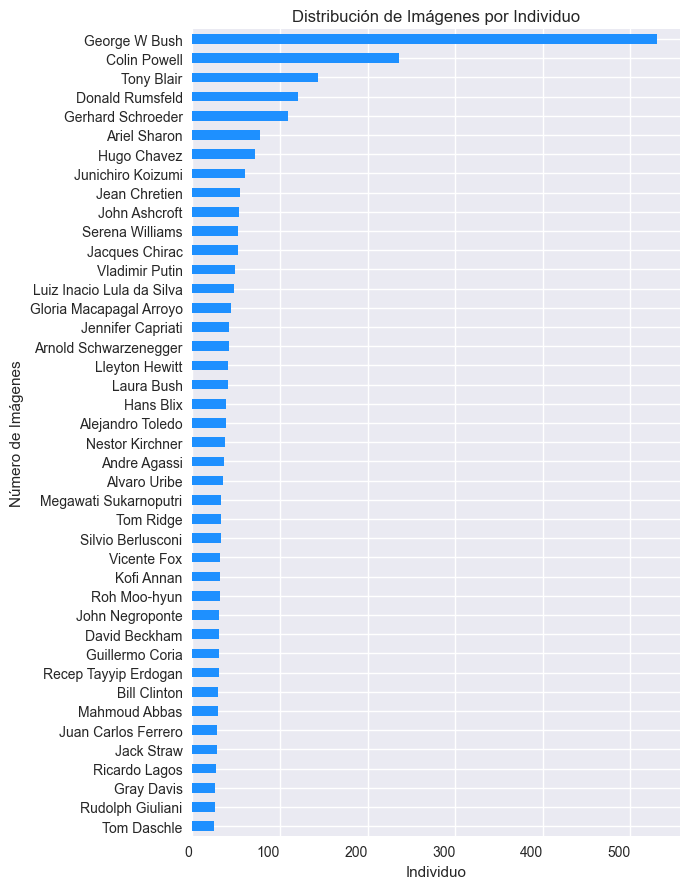

In [6]:
# Utilice este espacio para escribir el código.
unique, counts = np.unique(lfw_target, return_counts=True)
distribution = pd.DataFrame(data={'counts': counts}, index=lfw_target_names[unique])
distribution.sort_values(by='counts', ascending=True, inplace=True)

# Graficamos la distribución
plt.figure(figsize=(7, 9))
distribution['counts'].plot(kind='barh', color='dodgerblue')
plt.title('Distribución de Imágenes por Individuo')
plt.ylabel('Número de Imágenes')
plt.xlabel('Individuo')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

- ¿Cuántas imágenes pertenecen a Serena Williams? Grafíquelas 

Hay 52 imágenes de Serena Williams.


/var/folders/9p/gyxspb9x0t73hs4mh61tbjtw0000gn/T/ipykernel_1811/1407669430.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


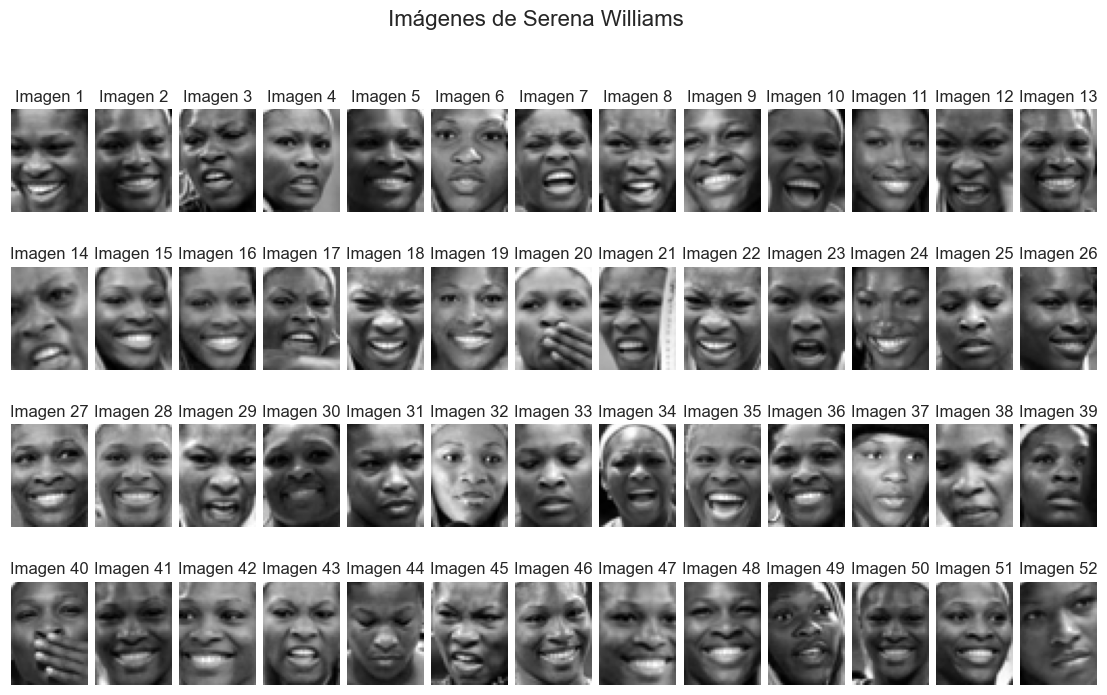

exit


In [7]:
# Utilice este espacio para escribir el código.
# Encontrar el índice y nombre de Serena Williams
serena_label = np.where(lfw_target_names == 'Serena Williams')[0][0]

# Filtrar las imágenes que corresponden a Serena Williams
serena_images = lfw_images[lfw_target == serena_label]
n_serena_images = len(serena_images)

print(f"Hay {n_serena_images} imágenes de Serena Williams.")

# Graficar las imágenes
fig, axes = plt.subplots(4, 13, figsize=(14, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

# Llenamos solo las subtramas necesarias
flat_axes = axes.flat
for i in range(n_serena_images):
    flat_axes[i].imshow(serena_images[i], cmap='gray')
    flat_axes[i].set_title(f"Imagen {i+1}")

# Ocultamos los ejes de las subtramas no utilizadas
for j in range(n_serena_images, len(flat_axes)):
    flat_axes[j].axis('off')

plt.suptitle("Imágenes de Serena Williams", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print('exit')


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

### 3.  Reconociendo rostros: las eigenfaces

Las eigenfaces son un conjunto de eigenvectors utilizados en el campo de la visión por computadora, principalmente en el reconocimiento de rostros. Son el resultado de reducir la dimensión de un gran conjunto de imágenes faciales, manteniendo la información que es más relevante para diferenciar las caras.

En este apartado buscaremos encontrar el espacio de menor dimensión manteniendo la información que es más relevante para diferenciar las caras. Lo haremos en etapas:


#### 3.1. Rostro promedio. 

Encuentre primero el "rostro promedio" y grafíquelo.  Para encontrar este rostro, necesita calcular el valor promedio de los pixeles. (*Tip: Si X es la matriz donde las filas representan las imágenes  y en las columnas el tono de gris de los píxeles, debería calcular el promedio para cada una de las columnas*).
 

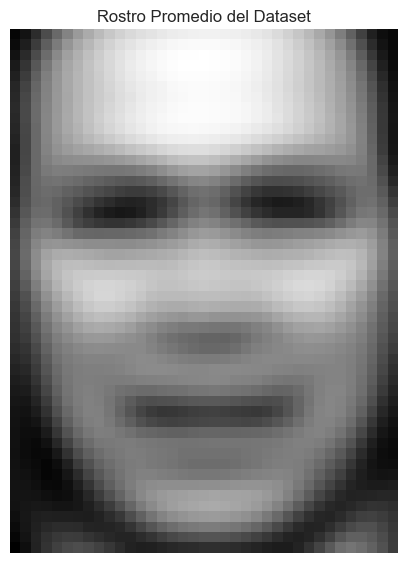

In [8]:
# Utilice este espacio para escribir el código.

# Calcular el promedio de los píxeles a través de todas las imágenes
# axis=0 significa que calculamos el promedio para cada columna (píxel)
average_face = lfw_data.mean(axis=0)

# Redimensionar el vector promedio a las dimensiones de una imagen (50x37)
average_face_image = average_face.reshape(h, w)

# Graficamos el rostro promedio
plt.figure(figsize=(5, 7))
plt.imshow(average_face_image, cmap='gray')
plt.title('Rostro Promedio del Dataset')
plt.xticks([])
plt.yticks([])
plt.show()

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.2. Reste el rostro promedio.

A cada una de las imágenes, reste el rostro promedio, es decir, reste la media a cada columna. Grafique las imágenes de Serena Williams luego de quitarle el rostro promedio.

/var/folders/9p/gyxspb9x0t73hs4mh61tbjtw0000gn/T/ipykernel_1811/1177716380.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


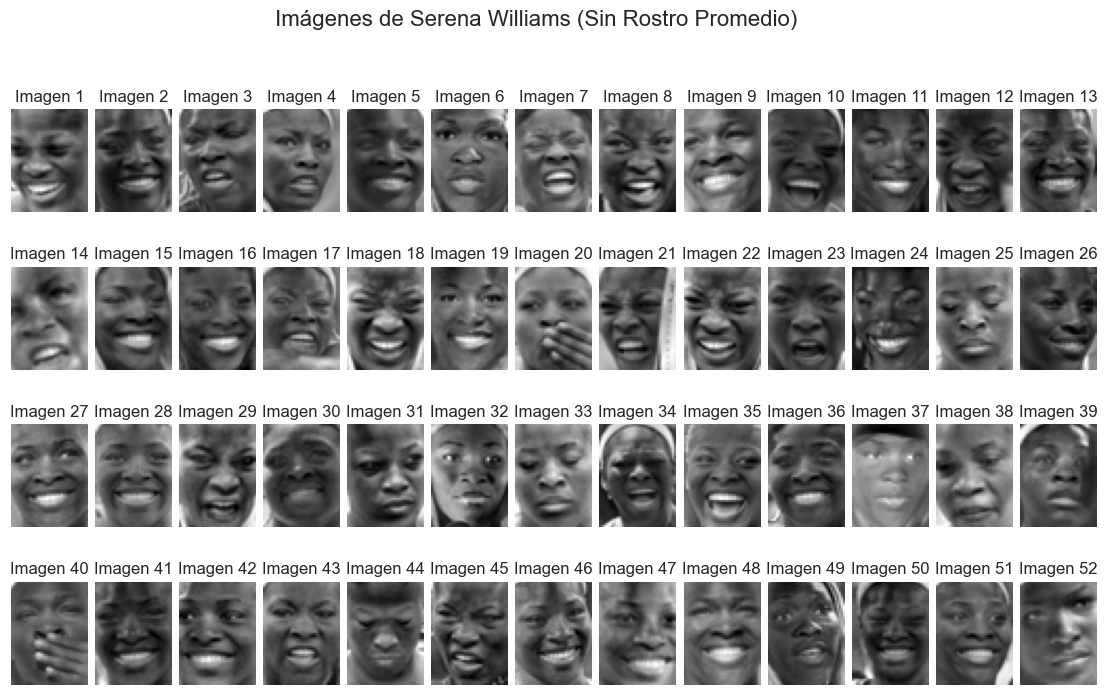

In [9]:
# Utilice este espacio para escribir el código.
# Utilice este espacio para escribir el código.
# Restamos el rostro promedio a cada imagen en el dataset
X_centered = lfw_data - average_face

# Filtramos las imágenes centradas de Serena Williams
serena_centered_images = X_centered[lfw_target == serena_label]

# Graficamos las imágenes centradas
fig, axes = plt.subplots(4, 13, figsize=(14, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

flat_axes = axes.ravel()
for i in range(n_serena_images):
    # Redimensionamos cada imagen centrada para poder graficarla
    img = serena_centered_images[i].reshape(h, w)
    flat_axes[i].imshow(img, cmap='gray')
    flat_axes[i].set_title(f"Imagen {i+1}")

for j in range(n_serena_images, len(flat_axes)):
    flat_axes[j].axis('off')

plt.suptitle("Imágenes de Serena Williams (Sin Rostro Promedio)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.3. Descomposición en Valores Singulares 

Aplique la Descomposición en Valores Singulares a estas nuevas imágenes y retenga solo $K=1000$ valores singulares? ¿Qué proporción de la varianza representan estos valores singulares?

Dimensiones de U: (2588, 1850)
Dimensiones de S: (1850,)
Dimensiones de Vt: (1850, 1850)
------------------------------
La proporción de la varianza explicada por los primeros 1000 valores singulares es: 0.9990


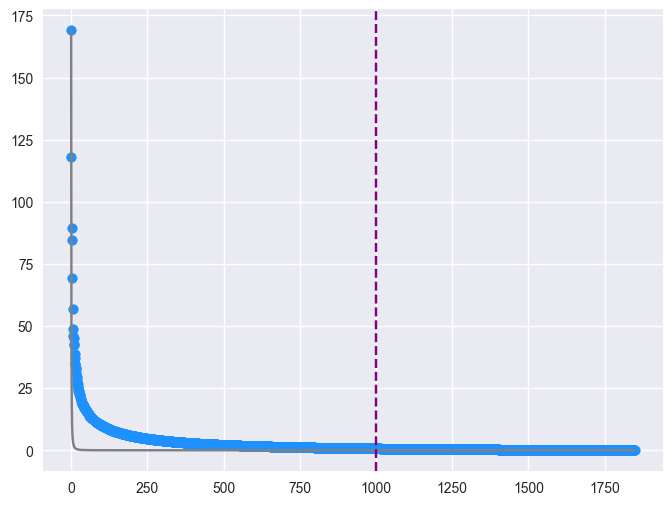

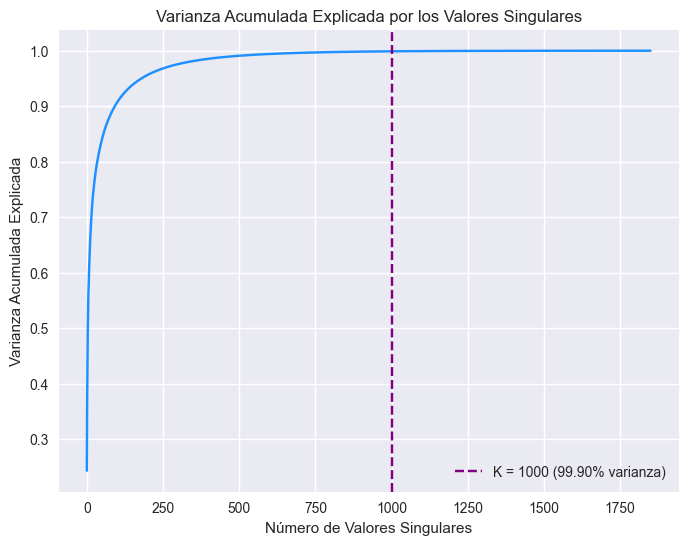

In [10]:
# Utilice este espacio para escribir el código.

# Aplicar SVD a la matriz de datos centrada
# full_matrices=False es más eficiente computacionalmente
U, S, Vt = svd(X_centered, full_matrices=False)

# Calcular la varianza explicada por cada valor singular
# La varianza es proporcional al cuadrado del valor singular
explained_variance = (S**2) / np.sum(S**2)

# Calcular la proporción de varianza acumulada por los primeros K=1000 valores
k = 1000
cumulative_variance_k = np.sum(explained_variance[:k])

print(f"Dimensiones de U: {U.shape}")
print(f"Dimensiones de S: {S.shape}")
print(f"Dimensiones de Vt: {Vt.shape}")
print("-" * 30)
print(f"La proporción de la varianza explicada por los primeros {k} valores singulares es: {cumulative_variance_k:.4f}")

# observe cuan rapidamente caen los SVD
idx = range(len(S))
func = [S[0]/((i+1) ** 2) for i in idx ]
plt.figure(figsize = (8, 6))
plt.plot(idx, func, color = 'gray')
plt.scatter(idx, S, color='dodgerblue')
plt.axvline(x=k, color='purple', linestyle='--', label=f'K = {k} ({cumulative_variance_k:.2%} varianza)')
plt.show()

# Graficar la varianza acumulada
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance), color='dodgerblue')
plt.title('Varianza Acumulada Explicada por los Valores Singulares')
plt.xlabel('Número de Valores Singulares')
plt.ylabel('Varianza Acumulada Explicada')
plt.grid(True)
plt.axvline(x=k, color='purple', linestyle='--', label=f'K = {k} ({cumulative_variance_k:.2%} varianza)')
plt.legend()
plt.show()

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.4. Representando los rostros en las bases

Las eigenfaces nos dice que cada rostro puede ser representado a partir de la aproximación a la matriz original por la matriz de dimensión reducida (determinada en el punto anterior), más el rostro promedio. Muestre que esto es posible para las imágenes de Serena Williams. Compare las imágenes reconstruidas con las originales.

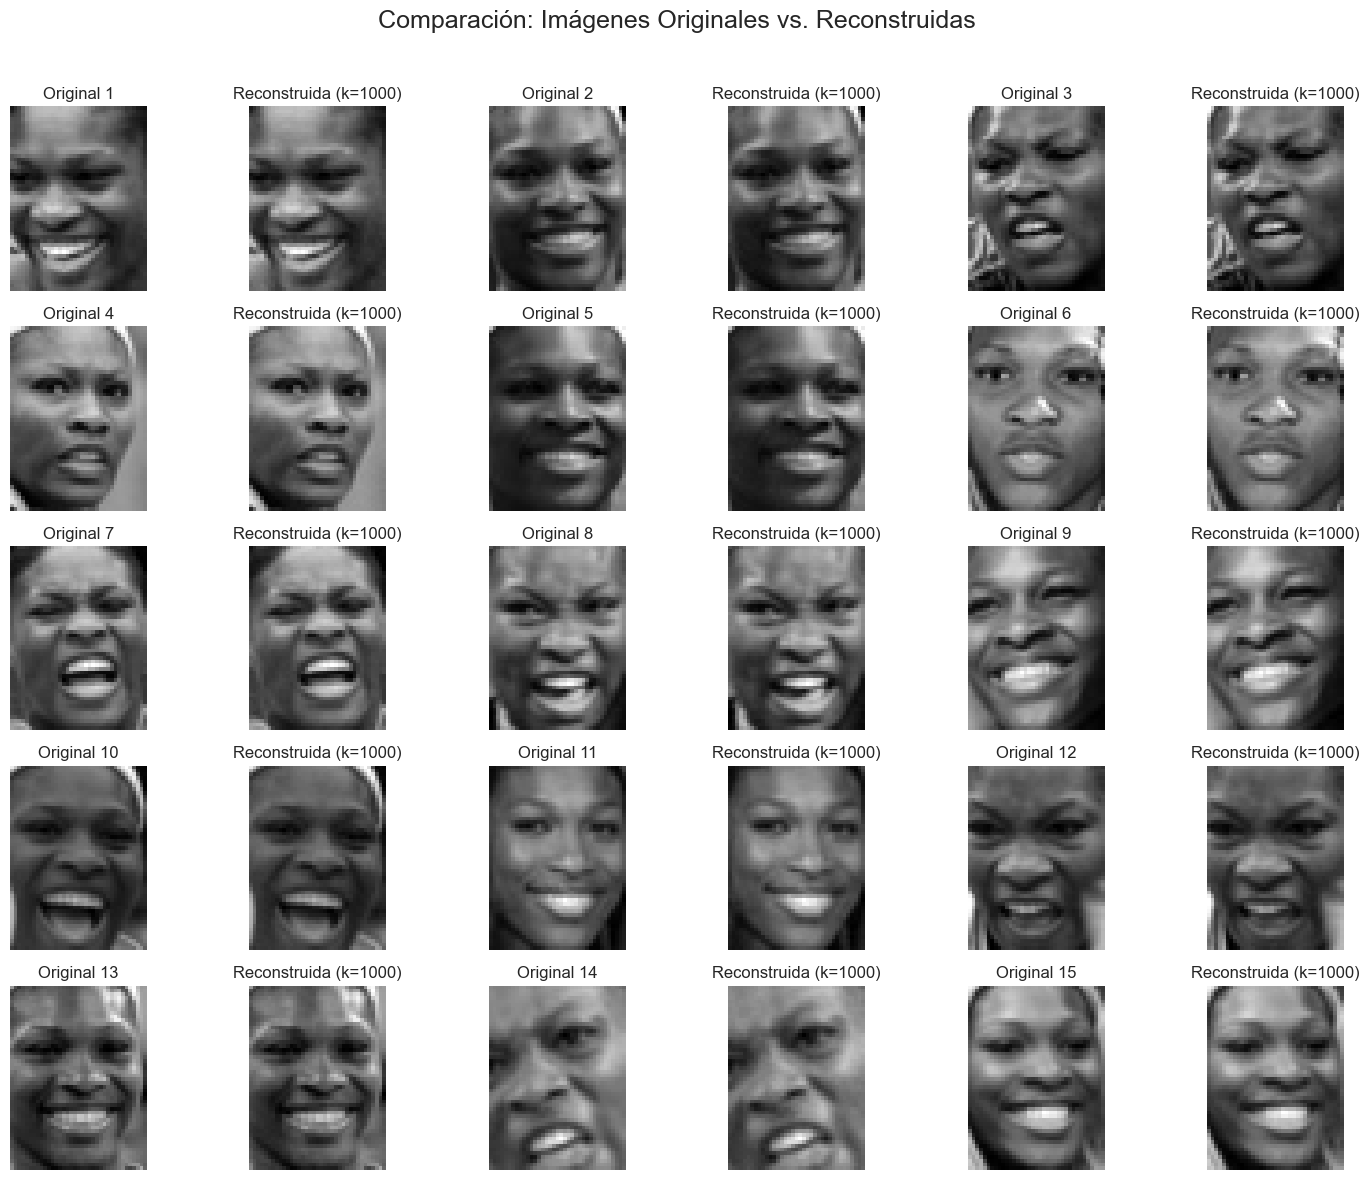

In [11]:
# Utilice este espacio para escribir el código.
# Utilice este espacio para escribir el código.
# 1. Proyectamos los datos centrados en el nuevo espacio de k componentes
#    La proyección se realiza multiplicando por Vt.T
X_projected = X_centered @ Vt.T[:, :k]

# 2. Reconstruimos los datos desde el espacio de dimensión reducida
#    La reconstrucción se realiza multiplicando por Vh
X_reconstructed = X_projected @ Vt[:k, :]

# 3. Añadimos de nuevo el rostro promedio para obtener la imagen final
X_reconstructed_final = X_reconstructed + average_face

# Filtramos las imágenes reconstruidas de Serena Williams
serena_reconstructed_images = X_reconstructed_final[lfw_target == serena_label]

# Graficamos las imágenes originales vs. las reconstruidas
fig, axes = plt.subplots(5, 6, figsize=(15, 12),
                         subplot_kw={'xticks':[], 'yticks':[]})

# Mostramos solo 15 pares para una mejor visualización
for i in range(15):
    # Imagen original
    ax = axes[i // 3, (i % 3) * 2]
    ax.imshow(lfw_images[lfw_target == serena_label][i], cmap='gray')
    ax.set_title(f"Original {i+1}")

    # Imagen reconstruida
    ax = axes[i // 3, (i % 3) * 2 + 1]
    ax.imshow(serena_reconstructed_images[i].reshape(h, w), cmap='gray')
    ax.set_title(f"Reconstruida (k={k})")

plt.suptitle("Comparación: Imágenes Originales vs. Reconstruidas", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

### 4. Uniendo Aprendizaje No Supervisado y Supervisado

Dado que cada rostro puede ser representado por las eigenfaces, y la relación que existe entre componentes principales y la SVD, esto sugiere que los componentes principales aquí determinados pueden servir de insumo para un algoritmo de clasificación de aprendizaje supervisado. En este sección del taller haremos esto.

Para ello construiremos un modelo de clasificación logístico para predecir si la imagen pertenece a `George W Bush`  (el individuo con más imágenes en la base)  o no.

#### 4.1. Identificando a `George W Bush`

Cree una variable binaria que tome el valor 1 si la imagen pertenece a `George W Bush` y 0 en caso contrario.

In [12]:
# Utilice este espacio para escribir el código.
# Buscar el ID numérico de George W Bush
bush_label = np.where(lfw_target_names == 'George W Bush')[0][0]

# Crear la variable objetivo (y)
# Será 1 si el target es igual a bush_label, 0 en otro caso.
y = (lfw_target == bush_label).astype(int)

# Verificar la distribución de la nueva variable
print(cleandoc(f"""
    El ID para 'George W Bush' es: {bush_label}")
    
    Distribución de la variable binaria 'y':")
      - 0 (No es Bush): {np.sum(y == 0)} imágenes
      - 1 (Es Bush):    {np.sum(y == 1)} imágenes
"""))

El ID para 'George W Bush' es: 9")

Distribución de la variable binaria 'y':")
  - 0 (No es Bush): 2058 imágenes
  - 1 (Es Bush):    530 imágenes


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 4.2. Bases de Entrenamiento y Prueba.

Divida la base utilizada anteriormente en dos: 80% de la base de imágenes asígnelas a la base de entrenamiento y el 20% restante a la de prueba, utilice un `random_state=10101`. 

In [13]:
# Utilice este espacio para escribir el código.

# Dividir los datos de imágenes (X) y la variable objetivo (y)
X_train, X_test, y_train, y_test = train_test_split(
    lfw_data,
    y,
    test_size=0.20,
    random_state=1,
    stratify=y  # Importante para mantener la proporción de clases
)

print(cleandoc(f"""
    Dimensiones de los conjuntos:"
        - X_train: {X_train.shape}
        - X_test:  {X_test.shape}
        - y_train: {y_train.shape}
        - y_test:  {y_test.shape}

    Proporción de la clase 'Bush' en cada conjunto:
        - Entrenamiento: {np.mean(y_train):.2%}
        - Prueba:        {np.mean(y_test):.2%}
"""))

Dimensiones de los conjuntos:"
    - X_train: (2070, 1850)
    - X_test:  (518, 1850)
    - y_train: (2070,)
    - y_test:  (518,)

Proporción de la clase 'Bush' en cada conjunto:
    - Entrenamiento: 20.48%
    - Prueba:        20.46%


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 4.3. Descomposición en Valores Singulares 

Para la base de entrenamiento y de prueba, realice la descomposición en valores singulares (Recuerde recentrar las matrices para que tenga media 0). 

In [14]:
# Utilice este espacio para escribir el código.
# 1. Calcular el rostro promedio SOLO en el conjunto de entrenamiento
mean_face_train = X_train.mean(axis=0)

# 2. Centrar ambos conjuntos (entrenamiento y prueba) USANDO EL PROMEDIO DE ENTRENAMIENTO
X_train_centered = X_train - mean_face_train
X_test_centered = X_test - mean_face_train

# 3. Aplicar SVD SOLO al conjunto de entrenamiento centrado
U_train, s_train, Vt_train = svd(X_train_centered, full_matrices=False)

print(cleandoc(f"""
    SVD completado en el conjunto de entrenamiento.
    Las eigenfaces (Vt_train) tienen dimensiones: {Vt_train.shape}
"""))

SVD completado en el conjunto de entrenamiento.
Las eigenfaces (Vt_train) tienen dimensiones: (1850, 1850)


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 4.4. Estimación de modelo de aprendizaje supervisado


Utilizando $k=1000$ valores singulares, construya los 1000 primeros componentes principales y úselos como predictores en su modelo logístico. Utilice como métrica de performance el porcentaje de imágenes de `George W Bush` clasificadas correctamente.

Para estimar su modelo logístico utilice el `solver='sag`,`random_state=10101` y `max_iter=1000`. Como se muestra a continuación:



In [15]:
from sklearn.linear_model import LogisticRegression

Modelo_Logistico = LogisticRegression(solver='sag',random_state=10101,max_iter=1000)

# Utilice este espacio para escribir el código restante.
# Número de componentes a utilizar
k = 1000

# 1. Proyectar los datos de entrenamiento y prueba sobre las primeras k eigenfaces
#    Las eigenfaces son las filas de Vt_train
X_train_pca = X_train_centered @ Vt_train.T[:, :k]
X_test_pca = X_test_centered @ Vt_train.T[:, :k]

print(cleandoc(f"""
    Nuevas dimensiones de los datos:
        - X_train_pca: {X_train_pca.shape}
        - X_test_pca:  {X_test_pca.shape}
"""))

# 2. Entrenar el modelo de Regresión Logística
Modelo_Logistico.fit(X_train_pca, y_train)

# 3. Realizar predicciones en el conjunto de prueba
y_pred = Modelo_Logistico.predict(X_test_pca)

# 4. Evaluar el rendimiento
# La métrica solicitada es el recall para la clase 1 (Bush)
recall_bush = recall_score(y_test, y_pred, pos_label=1)

print()
print(cleandoc(f"""
El porcentaje de imágenes de George W Bush 
clasificadas correctamente es: {recall_bush:.2%}

--- Reporte de Clasificación Completo ---
{classification_report(y_test, y_pred, target_names=['No Bush', 'Bush'])}
"""))

Nuevas dimensiones de los datos:
    - X_train_pca: (2070, 1000)
    - X_test_pca:  (518, 1000)

El porcentaje de imágenes de George W Bush 
clasificadas correctamente es: 73.58%

--- Reporte de Clasificación Completo ---
              precision    recall  f1-score   support

     No Bush       0.93      0.94      0.94       412
        Bush       0.77      0.74      0.75       106

    accuracy                           0.90       518
   macro avg       0.85      0.84      0.85       518
weighted avg       0.90      0.90      0.90       518


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 4.5. Mejorando el Ajuste

Trate ahora el número de valores singulares como un hiper-parámetro a encontrar. Emplee validación cruzada con 5 o 10 folds (dependiendo de su poder computacional) para encontrar el número óptimo de valores singulares. Con este modelo, evalúe el porcentaje de imágenes de `George W Bush` clasificadas correctamente en su muestra de prueba. Compare y discuta esta forma de elegir el número de variables con aquella utilizada en  4.4. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


In [18]:
# Utilice este espacio para escribir el código.

# 1. Crear un Pipeline
#    Este pipeline automatiza el proceso:
#    a) Aplicar PCA (que es equivalente a SVD para la proyección)
#    b) Entrenar la Regresión Logística
pipe = Pipeline([
    ('pca', PCA(svd_solver='randomized', random_state=1)),
    ('logistic', LogisticRegression(random_state=1, max_iter=1000, tol=1e-3))
])

# 2. Definir la grilla de hiperparámetros a probar
#    Probar diferentes números de componentes para PCA
#    Probar diferentes penalizaciones para la Regresión Logística
param_grid = {
    'pca__n_components': [50, 100, 150, 200, 250],
    'logistic__penalty': ['l1', None],
}

# 3. Configurar GridSearchCV
#    cv=10 significa validación cruzada de 10 folds.
#    scoring='recall' le dice que optimice para el recall de la clase positiva (Bush).
grid_search = GridSearchCV(pipe, param_grid, cv=10, scoring='recall', n_jobs=-1, verbose=1)

# 4. Ejecutar la búsqueda en los datos de entrenamiento originales
#    El pipeline se encarga del centrado y la transformación internamente
grid_search.fit(X_train, y_train)

# 5. Obtener los mejores resultados
print(cleandoc(f"""
    Mejor número de componentes encontrado: {grid_search.best_params_['pca__n_components']}
    Mejor puntuación de recall (en validación cruzada): {grid_search.best_score_:.2%}
"""))

# 6. Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
recall_bush_best = recall_score(y_test, y_pred_best, pos_label=1)

print()
print(cleandoc(f"""
El porcentaje de imágenes de George W Bush clasificadas correctamente
en el conjunto de prueba (con el modelo optimizado) es: {recall_bush_best:.2%}")

--- Reporte de Clasificación Completo (Modelo Optimizado) ---
{classification_report(y_test, y_pred_best, target_names=['No Bush', 'Bush'])}
"""))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/Users/ronaldmendoza/Documents/Ronald/Posgrados/Maestria/miad-andes/202514/cursos/AprendizajeNoSupervisado/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ronaldmendoza/Documents/Ronald/Posgrados/Maestria/miad-andes/202514/cursos/AprendizajeNoSupervisado/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ronaldmendoza/Documents/Ronald/Posgrados/Maestria/miad-andes/202514/cursos/AprendizajeNoSupervis

Mejor número de componentes encontrado: 200
Mejor puntuación de recall (en validación cruzada): 75.91%

El porcentaje de imágenes de George W Bush clasificadas correctamente
en el conjunto de prueba (con el modelo optimizado) es: 74.53%")

--- Reporte de Clasificación Completo (Modelo Optimizado) ---
              precision    recall  f1-score   support

     No Bush       0.94      0.96      0.95       412
        Bush       0.82      0.75      0.78       106

    accuracy                           0.92       518
   macro avg       0.88      0.85      0.86       518
weighted avg       0.91      0.92      0.91       518


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).